In [91]:
import pandas as pd
import numpy as np
import tldextract
import requests
import json
import warnings
import time
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop

import seaborn as sns
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from IPython.display import clear_output
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from PIL import Image
import os
import random
from IPython.display import clear_output
import time
plt.style.use('ggplot')
%matplotlib inline

In [3]:
ThreatActor1URLS = pd.read_csv('data/raw/ThreatActor1URLS.csv')

In [4]:
ThreatActor1URLS.shape

(1007, 1)

In [5]:
ThreatActor1URLS.head()

,URL
0,http://www.livroprossiga.com.br/modules/mod_po...
1,http://rbaconsultoria.com.br/administrator/hom...
2,http://momentsnoticerocks.com/easystreet/templ...
3,http://servicosreserve.hpw.com.br/Azul_LBR/Ate...
4,http://www.naylorantiques.com/ufi%20pnref%20st...


Check domain names used

In [7]:
ThreatActor1URLS['TLD'] = ThreatActor1URLS.URL.map(lambda url: tldextract.extract(url).registered_domain)

In [12]:
ThreatActor1URLS['TLD'].value_counts().shape[0]

99

In [11]:
tlds = ThreatActor1URLS.loc[ThreatActor1URLS['TLD'] != '', 'TLD'].value_counts(normalize=True).to_frame('num')
tlds.head()

,num
naylorantiques.com,0.415558
netshelldemos.com,0.070624
debbiebright.co.za,0.053224
waldronfamilygppractice.co.uk,0.038895
avea-vacances.com,0.033777


# Evaluate Efficiency of Current Threat Actor Strategy

** Note: ** I used [Swordphish](https://www.easysol.net/eng/resources/swordphish) API to calculate the probability of a URL being phish. BUT... You can use any algorithm/system that scores URLs and asseses a risk score.

In [13]:
ThreatActor1URLS['PhishingScore'] = -1

In [14]:
from SwordPhishCredentials import SwordPhish_APIKEY

api_url = 'https://api.easysol.io/swordphish/'
headers = {'Content-Type': 'application/json', 'apikey': SwordPhish_APIKEY, 'cache-control': 'no-cache'}

In [ ]:
for index, url in ThreatActor1URLS['URL'].iloc[:5].iteritems():
    req = requests.post(api_url, data=json.dumps({'urlArray': [url,], 'force_clf':True}), headers=headers, verify=False)

    if req.status_code == 200:
        ThreatActor1URLS.loc[index, 'PhishingScore'] = eval(req.text)[0]['phishing']
    else:
        print(req.status_code, req.reason)

In [ ]:
# Save DataFrame
ThreatActor1URLS.to_csv('data/processed/ThreatActor1URLS_p.csv')

In [15]:
# Read temp data for demo
ThreatActor1URLS = pd.read_csv('data/processed/ThreatActor1URLS_p.csv', index_col=0)

## Analyze Risk Scores

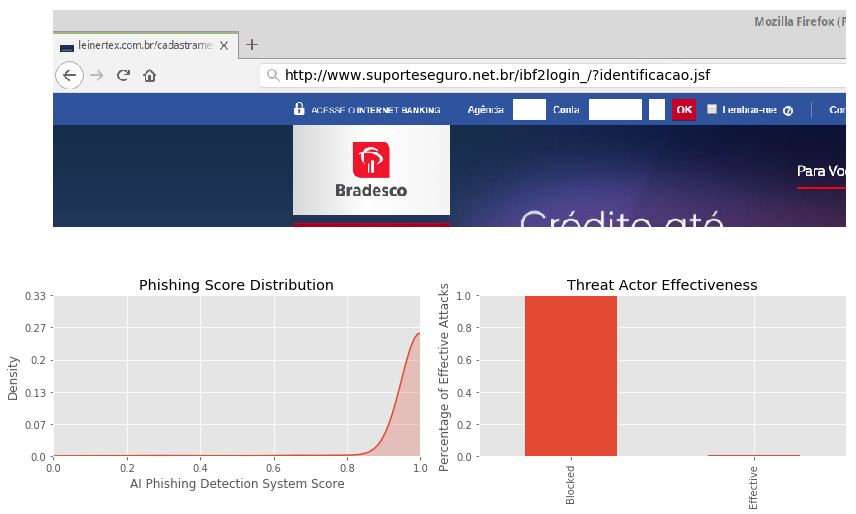

In [142]:
for i in range(ThreatActor1URLS.shape[0]):
    # Plot figure with subplots of different sizes
    fig = plt.figure(1, figsize=(15,12))
    # set up subplot grid
    gridspec.GridSpec(3,2)

    # large subplot
    plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2)
    plt.locator_params(axis='x', nbins=1)
    plt.locator_params(axis='y', nbins=1)
    img = Image.open('images/1.png')
    # crop
    width, height = img.size   # Get dimensions
    img = img.crop((0, 0, width/2, height/4))
    im = plt.imshow(img, animated=True)
    plt.axis('off')
    # Add red mask
    if ThreatActor1URLS['PhishingScore'].iloc[i] < 0.5:
        red = Image.new('RGB',img.size,(255,0,0))
        mask = Image.new('RGBA',red.size,(0,0,0,170))
        img = Image.composite(img,red,mask)
        im.set_array(img)        
    # Add URL
    # place a text box in upper left in axes coords
    plt.text(280, 70, ThreatActor1URLS['URL'].iloc[i][:75], fontsize=14, verticalalignment='top')

    # small subplot 2
    plt.subplot2grid((3,2), (2,0))
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    # Plotting the score distribution
    sns.kdeplot(ThreatActor1URLS['PhishingScore'].iloc[:i+1], bw=.05 ,shade=True,legend=False)
    plt.xlabel('AI Phishing Detection System Score')
    plt.ylabel('Density')
    plt.title('Phishing Score Distribution')
    plt.yticks(plt.yticks()[0], np.round(plt.yticks()[0] / np.sum(plt.yticks()[0]),2))
    plt.xlim(0,1)

    # small subplot 3
    plt.subplot2grid((3,2), (2,1))
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    blocked = (ThreatActor1URLS['PhishingScore'].iloc[:i+1] > 0.5).mean()
    pd.Series([blocked, 1-blocked], index=['Blocked', 'Effective']).plot(kind='bar', color='C0')
    plt.ylabel('Percentage of Effective Attacks')
    plt.title('Threat Actor Effectiveness')
    plt.ylim(0,1)

    # fit subplots and save fig
    fig.tight_layout()
    fig.set_size_inches(w=12,h=8)

    fig.savefig('images/ani1/img_' + str(i).zfill(4) + '.jpg')

plt.show()

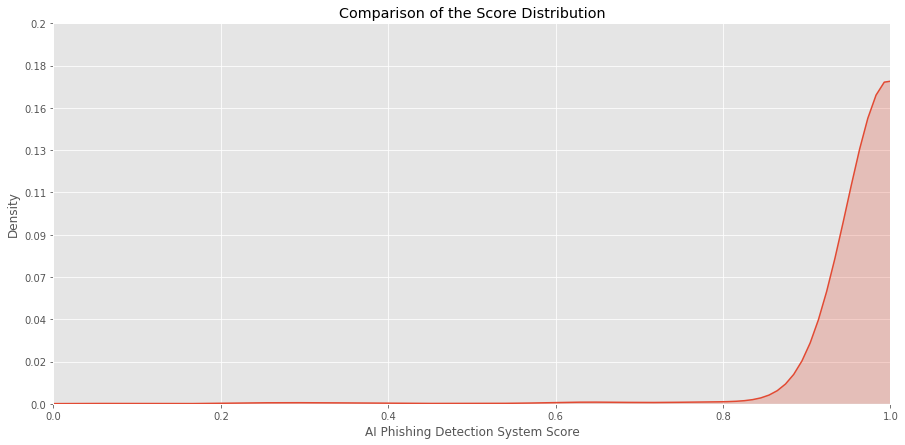

In [16]:
# Plotting the score distribution
f, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(ThreatActor1URLS['PhishingScore'], bw=.05 ,shade=True,legend=False)
plt.xlabel('AI Phishing Detection System Score')
plt.ylabel('Density')
plt.title('Comparison of the Score Distribution')
plt.yticks(plt.yticks()[0], np.round(plt.yticks()[0] / np.sum(plt.yticks()[0]),2))
ax.set_xlim(0,1);

In [17]:
threshold = 0.50
print('Total attacks:',ThreatActor1URLS.shape[0], '\nUsing a threshold equal to',threshold,' the # of effective URLs are',(ThreatActor1URLS['PhishingScore'] <= threshold).sum(),)

Total attacks: 1007 
Using a threshold equal to 0.5  the # of effective URLs are 7


# DeepPhish to generate new attacks

![](images/deepphish_training.PNG)

Cocateate effective URLs

In [18]:
threshold = 0.999

In [19]:
text = ''.join(ThreatActor1URLS.loc[ThreatActor1URLS['PhishingScore']<=threshold, 'URL'])

In [20]:
text[:300]

'http://www.naylorantiques.com/ufi%20pnref%20story/4yay8ic3http://www.naylorantiques.com/mp3/na%20ylor%20anhttp://www.naylorantiques.com/CustomerWeb/pages/24http://www.naylorantiques.com/identificacao.jsf/8http://www.naylorantiques.com/charset=iso-8859-1/GrammarState/Paragraphshttp://www.naylorantiqu'

## 2. Creating vocabulary 

First, we calculate how many different characters have each URL and build the vocabulary for the encoding of each attack.

In [21]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print('Total # characters in effective URLs:', len(text))
print('Lenght vocabulary (V):', len(chars))

Total # characters in effective URLs: 8516
Lenght vocabulary (V): 72


## 3. Feature creation
Once we have the vocabulary for our encoding, we define several technical parameters. Using these parameters, we will create the data set our algorithm will use to learn the features in each URL to start creating new ones with the same patterns
### Techincal parameters

In [22]:
maxlen = 200 # maximum # of characters in the same sentence 
step = 3     # size of step between each sentence

### Vectorization
We concatenate all effective URLs in one prose text, then we create "sentences" for each sample of the data set with lenght **maxlen**

In [23]:
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of created sentences (N):', len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of created sentences (N): 2772


Our final data set of features (*X*) is a *boolean* matrix with size **N** *x* **maxlen** *x* **V** 
The label to predict is the next character for each sentence, therefore the shape of *Y* is **N** *x* **V**

In [21]:
x.shape, y.shape

((2772, 200, 72), (2772, 72))

## 4. The Model
### Setting neural network architecture
We create a RNN using a LSTM layer and a dense layer. 

![](images/deepphish_model.PNG)

In [24]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               102912    
_________________________________________________________________
dense_1 (Dense)              (None, 72)                9288      
_________________________________________________________________
activation_1 (Activation)    (None, 72)                0         
Total params: 112,200
Trainable params: 112,200
Non-trainable params: 0
_________________________________________________________________


### Training
For the training process we use a **batch size** equal to 256 and 100 **epochs**. We include an additional parameter (**diversity**) to calibrate the variability of the prediction by just reajusting the probability distribution used to sample the prediction. In each iteration we see how it is learning our *DeepPhish* algorithm

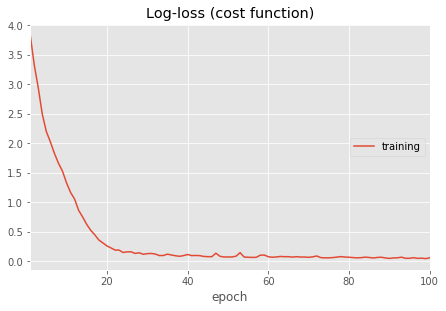

In [26]:
model.fit(x, y, batch_size=256, epochs=100, callbacks=[PlotLossesKeras()])

# Generate Synthetic URLs

![](images/deepphish_prediction.PNG)

#### Help functions

In [27]:
def sample(preds, diversity=1.2):
    '''
    Helper function to sample an index from a probability array
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / diversity
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_paths(generated):
    # Generate the next 400 characters
    for i in range(400):

        # Make the prediction
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated[i:]):
            x_pred[0, t, char_indices[char]] = 1.
        preds = model.predict(x_pred, verbose=0)[0]

        generated += indices_char[sample(preds)]
    
    # Split the generated paths
    generated_phish_paths = list(map(lambda x:x.replace(':', '').replace('//', ''), generated.split('http')))
    
    return generated_phish_paths

def generate_urls(generated_phish_paths):
    generated_phish_url = []
    
    # Add tld
    for path in generated_phish_paths:
        domain = tlds.iloc[(tlds['num']-random.random()).abs().argsort()].index[0]
        generated_phish_url.append('http://www.'+ domain +'/'+ path)
        
    return generated_phish_url

Iterate until the same number of URLs are generated

In [28]:
generated_phish_url = []

In [29]:
while len(generated_phish_url) < ThreatActor1URLS.shape[0]:

    # Randomly select the seed
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = text[start_index: start_index + maxlen]
    
    # Generate the paths
    generated_phish_paths = generate_paths(generated)

    # Delete if contain a domain 
    generated_phish_paths = [x for x in ['/'.join(path.split('/')[1:]) for path in generated_phish_paths] if len(x) > 4]
    
    # Generate URLs
    generated_phish_url.extend(generate_urls(generated_phish_paths))
    
    # Only generate the same number of URLs
    generated_phish_url = list(set(generated_phish_url))
    if len(generated_phish_url) > ThreatActor1URLS.shape[0]:
        generated_phish_url = generated_phish_url[:ThreatActor1URLS.shape[0]]
    
    clear_output()
    print(len(generated_phish_url), 'of', ThreatActor1URLS.shape[0])

1007 of 1007


In [30]:
generated_phish_url[-5:]

['http://www.naylorantiques.com/com_topics/Itemid=40734/article/2829268',
 'http://www.naylorantiques.com/ouWe/araisannise/londes20anicogr/2',
 'http://www.naylorantiques.com/docs/canais_atp/04',
 'http://www.naylorantiques.com/_zentiques.com/centr/loucomara-nhtom-cDe',
 'http://www.netshelldemos.com/Sukhwani%20Pacific/276/']

# Evaluate performance of Synthetic URLs

In [31]:
DeepPhishURLS = pd.DataFrame(generated_phish_url, columns=['URL'])
DeepPhishURLS['PhishingScore'] = -1

In [33]:
while DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] == -1].shape[0] > 0:
    
    print('TODO: ', DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] == -1].shape[0])
    
    for index, url in DeepPhishURLS['URL'].iteritems():

        if DeepPhishURLS.loc[index, 'PhishingScore'] == -1:

#             time.sleep(1)

            try:
                req = requests.post(api_url, data=json.dumps({'urlArray': [url,], 'force_clf':True}), headers=headers, verify=False)

                if req.status_code == 200:
                    DeepPhishURLS.loc[index, 'PhishingScore'] = eval(req.text)[0]['phishing']
                else:
                    print(index, req.status_code, req.reason)
            except:
                pass
                
    clear_output()

In [36]:
# Save DataFrame
DeepPhishURLS.to_csv('data/processed/DeepPhishURLS.csv')

In [37]:
# Read temp data for demo
DeepPhishURLS = pd.read_csv('data/processed/DeepPhishURLS.csv', index_col=0)

In [143]:
DeepPhishURLS.head()

,URL,PhishingScore
0,http://www.naylorantiques.com/home/HSBC,0.999497
1,http://www.naylorantiques.com/Rdi2tpnayloranti...,0.994191
2,http://www.naylorantiques.com/identificacao.js...,0.908721
3,http://www.netshelldemos.com/docs/canais_aendi...,0.001684
4,http://www.netshelldemos.com/centr/lo-coAcom/S...,0.997817


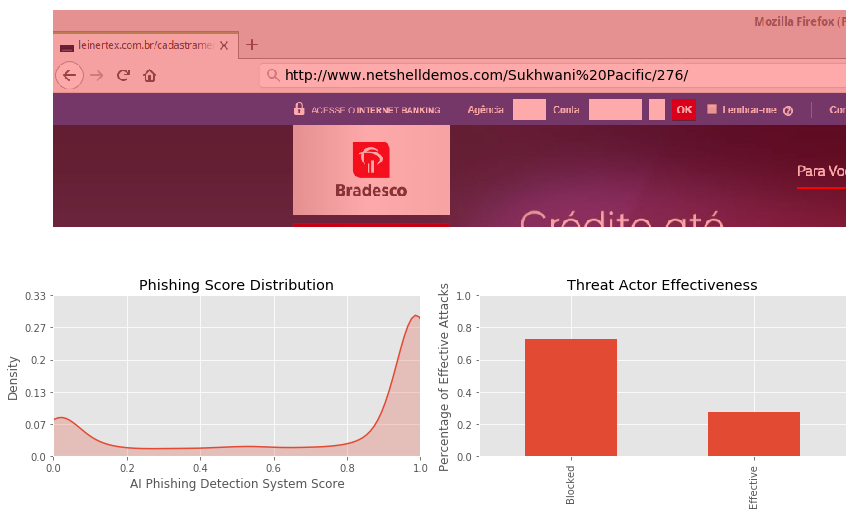

In [144]:
for i in range(DeepPhishURLS.shape[0]):
    # Plot figure with subplots of different sizes
    fig = plt.figure(1, figsize=(15,12))
    # set up subplot grid
    gridspec.GridSpec(3,2)

    # large subplot
    plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2)
    plt.locator_params(axis='x', nbins=1)
    plt.locator_params(axis='y', nbins=1)
    img = Image.open('images/1.png')
    # crop
    width, height = img.size   # Get dimensions
    img = img.crop((0, 0, width/2, height/4))
    im = plt.imshow(img, animated=True)
    plt.axis('off')
    # Add red mask
    if DeepPhishURLS['PhishingScore'].iloc[i] < 0.5:
        red = Image.new('RGB',img.size,(255,0,0))
        mask = Image.new('RGBA',red.size,(0,0,0,170))
        img = Image.composite(img,red,mask)
        im.set_array(img)   
        
    # Add URL
    # place a text box in upper left in axes coords
    plt.text(280, 70, DeepPhishURLS['URL'].iloc[i][:75], fontsize=14, verticalalignment='top')

    # small subplot 2
    plt.subplot2grid((3,2), (2,0))
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    # Plotting the score distribution
    sns.kdeplot(DeepPhishURLS['PhishingScore'].iloc[:i+1], bw=.05 ,shade=True,legend=False)
    plt.xlabel('AI Phishing Detection System Score')
    plt.ylabel('Density')
    plt.title('Phishing Score Distribution')
    plt.yticks(plt.yticks()[0], np.round(plt.yticks()[0] / np.sum(plt.yticks()[0]),2))
    plt.xlim(0,1)

    # small subplot 3
    plt.subplot2grid((3,2), (2,1))
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    blocked = (DeepPhishURLS['PhishingScore'].iloc[:i+1] > 0.5).mean()
    pd.Series([blocked, 1-blocked], index=['Blocked', 'Effective']).plot(kind='bar', color='C0')
    plt.ylabel('Percentage of Effective Attacks')
    plt.title('Threat Actor Effectiveness')
    plt.ylim(0,1)

    # fit subplots and save fig
    fig.tight_layout()
    fig.set_size_inches(w=12,h=8)

    fig.savefig('images/ani2/img_' + str(i).zfill(4) + '.jpg')

plt.show()

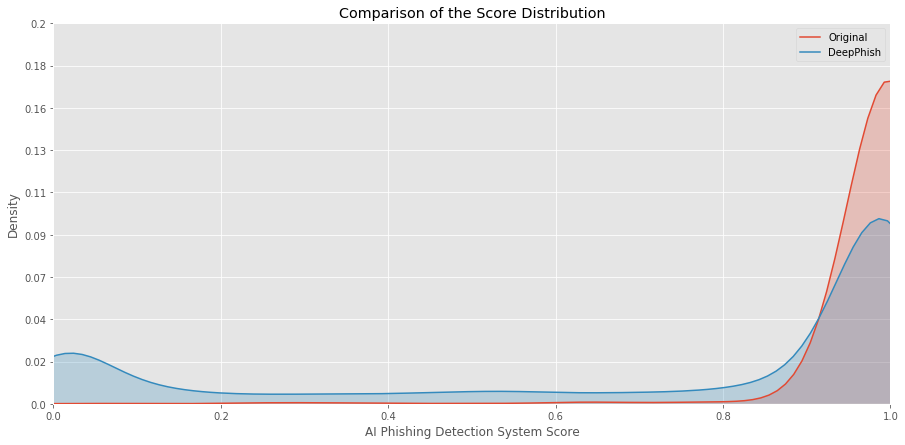

In [39]:
# Plotting the score distribution
f, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(ThreatActor1URLS['PhishingScore'], bw=.05 ,shade=True,label='Original')
sns.kdeplot(DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] != -1, 'PhishingScore'], bw=.05 ,shade=True,label='DeepPhish')

plt.xlabel('AI Phishing Detection System Score')
plt.ylabel('Density')
plt.title('Comparison of the Score Distribution')
plt.yticks(plt.yticks()[0], np.round(plt.yticks()[0] / np.sum(plt.yticks()[0]),2))
ax.set_xlim(0,1);

In [40]:
threshold = 0.5

res = pd.DataFrame([[ThreatActor1URLS.shape[0], (ThreatActor1URLS['PhishingScore'] <= threshold).sum()]],
                   index=['Threat Actor 1'], columns=['# URLs', 'Effective URLS'])
res.loc['DeepPhish'] = [DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] != -1, 'PhishingScore'].shape[0], (DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] != -1, 'PhishingScore'] <= threshold).sum()]
res['Effective %'] = res['Effective URLS'] / res['# URLs']
res.style.set_properties(**{'font-size':'20pt'})
display(res)

,# URLs,Effective URLS,Effective %
Threat Actor 1,1007,7,0.006951
DeepPhish,1007,273,0.271102


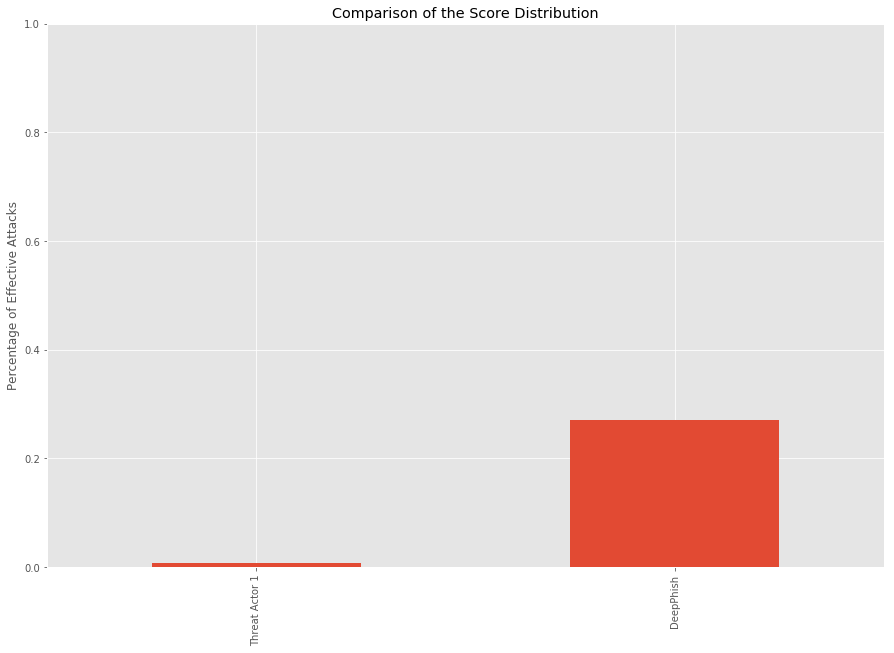

In [41]:
# Plot of the results

threshold = 0.5

res = pd.DataFrame([[ThreatActor1URLS.shape[0], (ThreatActor1URLS['PhishingScore'] <= threshold).sum()]],
                   index=['Threat Actor 1'], columns=['# URLs', 'Effective URLS'])
res.loc['DeepPhish'] = [DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] != -1, 'PhishingScore'].shape[0], (DeepPhishURLS.loc[DeepPhishURLS['PhishingScore'] != -1, 'PhishingScore'] <= threshold).sum()]
res['Effective %'] = res['Effective URLS'] / res['# URLs']

f, ax = plt.subplots(figsize=(15,10))

res['Effective %'].plot(kind='bar', color='C0')
# sns.kdeplot(ThreatActor1URLS['PhishingScore'], bw=.05 ,shade=True,label='Original')
# sns.kdeplot(DeepPhishURLS['PhishingScore'], bw=.05 ,shade=True,label='DeepPhish')

plt.ylabel('Percentage of Effective Attacks')
plt.title('Comparison of the Score Distribution')
# plt.yticks(plt.yticks()[0], np.round(plt.yticks()[0] / np.sum(plt.yticks()[0]),2))
ax.set_ylim(0,1);